In [1]:
# to access functions from root directory
import sys
sys.path.append('/data/ad181/RemoteDir/rl_robust_owc')

In [2]:
%matplotlib notebook
import os
import pickle
import numpy as np 
import matplotlib.pyplot as plt  
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

from utils.clustering_functions import get_connectivity_dist_mat
from k_distributions.generate_k_channel import batch_generate

In [3]:
seed=1

case = 'case_1'
data_dir = './'+case
os.makedirs(data_dir, exist_ok=True)

with open('../envs_params/env_data/env_train.pkl', 'rb') as input:
    env = pickle.load(input)

compute connectivity distances...



form distance matrix...


<IPython.core.display.Javascript object>


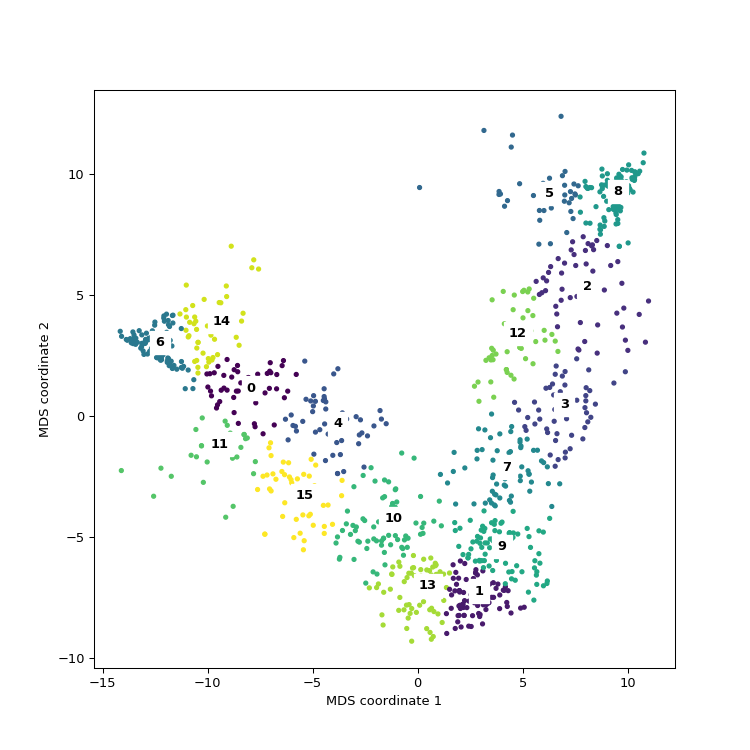

In [4]:
# generate N=1000 samples of the uncertainty distribution
n_samples=1000
low_log_k = -2
high_log_k = 5.5
k_samples_md = batch_generate(nx=env.grid.nx, ny=env.grid.ny, lx=env.grid.lx, ly=env.grid.ly, 
                         channel_k=high_log_k, base_k=low_log_k, channel_width_range=(0.1,0.3), 
                         sample_size=n_samples, seed=seed+10)
md_m2_conv = 1/1.01325e+15
k_samples = md_m2_conv*np.exp(k_samples_md) 

# locations x'' in equation 7
list_x, list_y = list(range(env.grid.nx)), list(range(env.grid.ny))
x,y = np.meshgrid(list_x[::15], list_y[::15])
x_loc, y_loc = x.ravel(), y.ravel()

# generate the clustering using MDS data
dist_matrix = get_connectivity_dist_mat(k_samples, env, x_loc, y_loc)
embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=seed)
X_transformed = embedding.fit_transform(dist_matrix)

# number of clusters l=16
clusters = 16
km = KMeans(n_clusters=clusters, random_state=seed)
y_pred = km.fit_predict(X_transformed)
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, X_transformed)

plt.figure(figsize=(8,8))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_pred, marker='.')
for i, idx in enumerate(closest):
    plt.text(X_transformed[idx, 0], X_transformed[idx, 1], str(i), backgroundcolor='white', fontweight='bold')
plt.xlabel('MDS coordinate 1')
plt.ylabel('MDS coordinate 2')
plt.savefig(data_dir+'/'+case+'_k_cluster.pdf')